In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import math
from qutip import *
import random
from math import pi
# Qiskit modules
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, IBMQ
from qiskit import execute
import qiskit.tools.visualization
from qiskit.tools.visualization import circuit_drawer, plot_histogram
from qiskit.quantum_info import state_fidelity
from multiprocessing import Process, Manager,Lock





# Plot results
def graphic(PN,iterations,dec_times,P,N,E1,E2,angle_u,init,coupling_values,precision,shots):
    #  Required variable delcarations
    x=[]
    y1=[]
    y2=[]
    p1=0
    p2=0
    for cycles in range(0,iterations):
        if __name__ == '__main__':  # for each simulation for a time t, create P processes
            manager=Manager()
            my_l = Lock()
            processes=[]
            V = manager.dict()
            V['0']=0
            V['1']=0
            for i in range(0,P):
                p = Process(target = execute_N,args=(my_l,V,N,E1,E2,angle_u,dec_times,cycles,init,coupling_values,precision,shots))
                processes.append(p)
            for u in processes:
                u.start()
            for u in processes:
                u.join()
                
        # Get the population terms (probability), divide by the number of the total algorithm runs
            p1+=V['0']/PN
            p2+=V['1']/PN
        x.append(dec_times[0]*cycles)
        y1.append(p1)
        y2.append(p2)
        p1=0
        p2=0
        
    #Plot
    la = plt.scatter(x,y1,c='b',marker="^",label='Simulation - P(0)')
    lb = plt.scatter(x,y2,c='r',label='Simulation - P(1)')
    ll = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    lx = plt.xlabel('Time (ps)')
    ly = plt.ylabel('Probability')
    xx = plt.xlim(0,cycles*dec_times[0])
    plt.show()
    
    


# Basis transformation matrix
def u(fret,exc,angle_u):
    fret.ry(-2*angle_u,exc[0])

# Evolution operator of the diagonal Hamiltonian
def hamiltonian_evolution(fret,exc,out,phase_step,E1,E2):
    ## 0
    fret.barrier()
    fret.x(exc[0])
    fret.crz(-2*E1*phase_step,exc[0],out[0])
    fret.x(exc[0])
    ## 1
    fret.barrier()
    fret.crz(-2*E2*phase_step,exc[0],out[0])
    
# Transconjugate basis transformation matrix
def u_transconj(fret,exc,angle_u): 
    fret.ry(2*angle_u,exc[0])

    
    
    
    
# generate the necessary random numbers
def random_generator(cycles,precision):
    n_values = cycles*2 # number of required random numbers a fluctuator-pair
    values = ''     # list of random numbers for each fluctuator-pair
    randl=[]                # list containing all the fluctuator-pair random number lists 
                            # (because there can be more than one fluctuator acting in each molecule)
    # create the random numbers and add them to the respective lists
    for j in range(precision): 
        for i in range(n_values):
            values += str(random.randint(0,1))
        randl.append(values)
        values=''
    return randl
# randl[i] gives the list of random numbers correspondent to the fluctuator-pair "i". 
# randl[i][j] gives a random number in the index "j" correspondent to the fluctuator-pair "i".

# Apply the interaction evolution operator for each molecule (without the selection of system's state)
def apply_single_h_random(nat,exc,out,random_values,index_random,j,dec_times,coupling_values,precision,n_mol):
    # "j" denotes the current cycle, "dec_times[0]" the iteration time-step.
    for i in range(precision): # "i" denotes a fluctuator-pair
        if((j*dec_times[0])%dec_times[i+1]==0.0): # if it is time to apply a new random value (switching act)
            
            if(random_values[i][index_random[i]]=='0'):          # if '0', then apply sign -
                nat.crz(-coupling_values[i]*dec_times[0],exc[0],out[0])
            elif(random_values[i][index_random[i]]=='1'):        # if '1', then apply sign +
                nat.crz(coupling_values[i]*dec_times[0],exc[0],out[0])
            index_random[i] = index_random[i]+1         # increment the index which points to a new random value
            
        else:                               # if it is not time to apply a switching act 
                                            # (do not increment the index which points to a new random value)
            
            if(n_mol==0):  # i.e. donor molecule, so get the random value used in its last interaction with the 
                           # respective fluctuator in the fluctuator-pair "i"
                if(random_values[i][index_random[i]-2]=='0'):   
                        nat.crz(-coupling_values[i]*dec_times[0],exc[0],out[0])
                elif(random_values[i][index_random[i]-2]=='1'):
                        nat.crz(coupling_values[i]*dec_times[0],exc[0],out[0])
                        
            else:          # if acceptor molecule, get the random value used in its last interaction with the 
                           # respective fluctuator in the fluctuator-pair "i"
                if(random_values[i][index_random[i]-1]=='0'):
                        nat.crz(-coupling_values[i]*dec_times[0],exc[0],out[0])
                elif(random_values[i][index_random[i]-1]=='1'):
                        nat.crz(coupling_values[i]*dec_times[0],exc[0],out[0])

    return(index_random) # return the index of the present random number


# Apply system's state selection and call the function to apply the interaction evolution operator
def system_bath_evolution_random(nat,exc,out,i,dec_times,random_values,index_random,coupling_values,precision):
    # 0
    nat.x(exc[0])
    index_random = apply_single_h_random(nat,exc,out,random_values,index_random,i,dec_times,coupling_values,precision,0)
    nat.x(exc[0])
    nat.barrier() 
    #1
    index_random = apply_single_h_random(nat,exc,out,random_values,index_random,i,dec_times,coupling_values,precision,1)
    return(index_random)

# Decides the initial state of the system and initializes the ancilla "out" to state 1.
def state_initialization_random(nat,exc,out,init):
    nat.x(out[0])
    if (init):
        nat.x(exc[0])
        
        
        
        
        
# Apply the quantum circuit
def one_qubit_nat_random(nat,exc,out,cr,E1,E2,angle_u,dec_times,cycles,init,random_values,coupling_values,precision):
    index_random = []  
    # the index of this list, denotes a fluctuator-pair. The value correspondent to an index "i" denotes 
    # the index of the random number in the list of lists of random numbers "randl", i.e. randl[i][index_random[i]]
    # points to a new random number correspondent to the fluctuator-pair "i".
    
    for i in range(len(coupling_values)): # all fluctuator-pairs start at the index 0.
        index_random.append(0)
        
    state_initialization_random(nat,exc,out,init)
    nat.barrier()
    for i in range(0,cycles): # iteration procedure
        u(nat,exc,angle_u)
        hamiltonian_evolution(nat,exc,out,dec_times[0],E1,E2)
        nat.barrier()
        u_transconj(nat,exc,angle_u)
        nat.barrier()
        index_random = system_bath_evolution_random(nat,exc,out,i,dec_times,random_values,index_random,coupling_values,precision)
        # index random as input and output at every iteration to keep its current value.
        nat.barrier()
    nat.measure(exc,cr)

    
    
    
    
# execute N different runs of the quantum algorithm in each process:
def execute_N(my_l,V,N,E1,E2,angle_u,dec_times,cycles,init,coupling_values,precision,shotss):
    
    backend_sim = Aer.get_backend('qasm_simulator')
    coupling_values_=[]
    dec_times_=[]
    # Concurrency control with a lock "my_l": create new variables in each process to read the input parameters
    my_l.acquire()
    shots_=shotss
    angle_u_=angle_u
    E1_=E1
    E2_=E2
    init_=init
    precision_=precision
    cycles_=cycles
    N_=N
    dec_times_.append(dec_times[0])
    for i in range(precision):
        coupling_values_.append(coupling_values[i])
        dec_times_.append(dec_times[i+1])
    my_l.release()
    
    # For each run, create a new quantum circuit and new random values
    for i in range(N_):
        exc = QuantumRegister(1) # 2 molecules
        out = QuantumRegister(1) # 1 ancilla initialized at state 1
        cr = ClassicalRegister(1) # 1 classical bit to measure the system's state
        nat = QuantumCircuit(exc,out,cr)
        
        random_values = random_generator(cycles_,precision_)
        one_qubit_nat_random(nat,exc,out,cr,E1_,E2_,angle_u_,dec_times_,cycles_,init_,random_values,coupling_values_,precision_)
        job_sim = execute(nat, backend_sim, shots=shots_)
        result_sim = job_sim.result()
        result_counts = result_sim.get_counts(nat)
        
        # Concurrency control : Add the probability of measuring each state "k" in each run to a global dictionary
        # (which can be utilized by every process). In function "graphic", will be divided by "PN" 
        # (the number of all runs of the simulation).
        my_l.acquire()
        for k in result_counts:
            V[k]+=result_counts[k]/shots_
        my_l.release()




cycles=10  # number of points in the plot. Number of times "t" which the system is simulated.
c=0.0299792 #speed of light in units cm/ps

# NON-RESONANT PARAMETERS
#E1=81227.5*c
#E2=77108.8*c
#angle_u=2.934
#coupl=132*c*2*pi

# NEAR-RESONANT PARAMETERS
E1=82219*c          # energy eigenvalue 1 in rad.THz
E2=80515.5*c        # energy eigenvalue 2 in rad.THz 
angle_u=2.545       # angle to be used in the basis transformation matrix
coupl=126*c*2*pi    # coupling strength in rad.THz (used when plotting also the classical algorithm results)


g1=300*c*2*pi  # fluctuation strength, in units rad.THz, of the first fluctuator-pair 
               # (two identical fluctuators, where each acts in one molecule)

dec_times=[0.008, 0.08]      # first element = iteration time-step, each of the following elements
                             # denote the fluctuator waiting time of each fluctuator-pair.

init=False # decides the initial state of the system
coupling_values=[g1] 
# list of coupling strengths, add more, to have more fluctuators acting identically in each molecule. 
# For instance, one element, denotes two identical fluctuators acting each in one of the molecules (fluctuator-pair). 
# Index "i" corresponds to the fluctuator waiting time of the index "i+1" in "dec_times".
precision=len(coupling_values) # number of fluctuator-pairs

P = 50 # number of processes
N = 5 # number of different algorithm runs in each process
PN=P*N  # number of total runs of the algorithm
shots=5000 # number of shots performed in the quantum circuit for each run


#UNCOMMENT THE FOLLOWING LINES, TO SEE THE QUANTUM CIRCUIT (and comment the "graphic(...)" call):
#exc = QuantumRegister(1) # 1 qubit for exciton localizations
#out = QuantumRegister(1) # 1 output qubit to apply diagonal hamiltonian
#cr = ClassicalRegister(1) # 1 classical bit for state measurement
#nat = QuantumCircuit(exc,out,cr)
#random_values = random_generator(cycles,precision)
#one_qubit_nat_random(nat,exc,out,cr,E1,E2,angle_u,dec_times,cycles,init,random_values,coupling_values,precision)
#nat.draw(output='mpl')



graphic(PN,cycles,dec_times,P,N,E1,E2,angle_u,init,coupling_values,precision,shots)

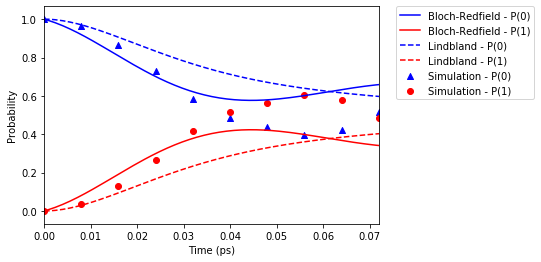

In [6]:
# If the results with the classical algorithms want to be observed, then:

# Substitute the definition of the function "graphic" to the following one:

def graphic(PN,iterations,dec_times,P,N,E1,E2,angle_u,init,coupling_values,gamma_lind,coupl,precision,shots):
    #  Required variable delcarations
    x=[]
    y1=[]
    y2=[]
    p1=0
    p2=0
    for cycles in range(0,iterations):
        if __name__ == '__main__':  # for each simulation for a time t, create P processes
            manager=Manager()
            my_l = Lock()
            processes=[]
            V = manager.dict()
            V['0']=0
            V['1']=0
            for i in range(0,P):
                p = Process(target = execute_N,args=(my_l,V,N,E1,E2,angle_u,dec_times,cycles,init,coupling_values,precision,shots))
                processes.append(p)
            for u in processes:
                u.start()
            for u in processes:
                u.join()
                
        # Get the population terms (probability), divide by the number of the total algorithm runs
            p1+=V['0']/PN
            p2+=V['1']/PN
        x.append(dec_times[0]*cycles)
        y1.append(p1)
        y2.append(p2)
        p1=0
        p2=0
        
    # Bloch-Redfield Solver
    g=coupling_values[0]
    J=coupl*tunneling(2,1)    # off-diagonal elements of the Hamiltonian
    energ=qdiags([E1,E2],0)   # diagonal elements of the Hamiltonian
    H=energ+J                 # system Hamiltonian
    init=fock_dm(2,0)         # initial density matrix (excited donor molecule)
    tlist = np.linspace(0, 50*0.008, 500)      # list of times
    exp_operators=[qdiags([1,0],0),qdiags([0,1],0)] 
    # Measurement:expectation value of the projection operators (population terms)
    
    gamma=125 # switching rate of the fluctuators
    def lorentzian_spectrum(w): # Define the fluctuator set spectral density
        return np.power(g,2)*gamma/((np.power(w,2)+np.power(gamma,2)))
    
    # Solve the Bloch-Redfield equation
    output = brmesolve(H, init, tlist, a_ops=[[qdiags([1,0],0),lorentzian_spectrum],[qdiags([0,1],0),lorentzian_spectrum]], e_ops=exp_operators)
    
    # Lindbland equation Solver
    init=fock_dm(2,0) # initial density matrix (excited donor molecule)
    # Solve the equation:
    output_lind = mesolve(H, init, tlist, [np.sqrt(gamma_lind)*qdiags([1,0],0),np.sqrt(gamma_lind)*qdiags([0,1],0)], exp_operators)
    
    #Plot
    laa=plt.plot(tlist, output.expect[0],c='b',label='Bloch-Redfield - P(0)')
    lbb=plt.plot(tlist, output.expect[1],c='r',label='Bloch-Redfield - P(1)')
    laal=plt.plot(tlist, output_lind.expect[0],c='b',linestyle='--',label='Lindbland - P(0)')
    lbbl=plt.plot(tlist, output_lind.expect[1],c='r',linestyle='--',label='Lindbland - P(1)')
    la = plt.scatter(x,y1,c='b',marker="^",label='Simulation - P(0)')
    lb = plt.scatter(x,y2,c='r',label='Simulation - P(1)')
    ll = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    lx = plt.xlabel('Time (ps)')
    ly = plt.ylabel('Probability')
    xx = plt.xlim(0,cycles*dec_times[0])
    plt.show()
    
    
# And comment the previous "graphic" function call and substitute it by the following call and variable initialization:

gamma_lind=70  # dephasing rate parameter of the lindbland equation (in THz).
graphic(PN,cycles,dec_times,P,N,E1,E2,angle_u,init,coupling_values,gamma_lind,coupl,precision,shots)